Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 60)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, StratifiedKFold
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import ndcg_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder, KBinsDiscretizer, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, PolynomialFeatures
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_regression, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.compose import TransformedTargetRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.wsd import lesk
from nltk import ngrams
nltk.download('cmudict')
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
import pickle5 as pkl
import json
import matplotlib.pyplot as plt
import os
import ast
import inspect
from utils import *
import re
from scipy.stats import rankdata, pearsonr, spearmanr, stats
from imblearn.over_sampling import SMOTE
import smogn
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.distributions.empirical_distribution import ECDF
from collections import Counter
import random
from scipy import stats
from functools import partial
import pylab as p
import mpl_toolkits.mplot3d.axes3d as p3
from xgboost import XGBRegressor
import math
from datamuse import datamuse
import urllib
import time
import requests
from functools import lru_cache
from itertools import product as iterprod
from mlxtend.feature_selection import SequentialFeatureSelector

[nltk_data] Downloading package cmudict to /dartfs-
[nltk_data]     hpc/rc/home/c/f0035qc/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
[nltk_data] Downloading package wordnet to /dartfs-
[nltk_data]     hpc/rc/home/c/f0035qc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /dartfs-
[nltk_data]     hpc/rc/home/c/f0035qc/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package cmudict to /dartfs-
[nltk_data]     hpc/rc/home/c/f0035qc/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


# Incoming from macbook

In [12]:
job = 'pickle'
path = './data/'+job
if not os.path.isdir(path): os.mkdir(path)
if not os.path.isdir(path+'/macbook/'): os.mkdir(path+'/macbook/')
if not os.path.isdir(path+'/colab/'): os.mkdir(path+'/colab/')

# Extract discovery features
- Run `gigaword_for_multi.py`.
- Combine `{name}_{feature_name}.tsv`'s into `{name}_y.tsv`.
- Create log-transformed features.

In [ ]:
join_discovery_features(job, 'multi_train', multi=True)
join_discovery_features(job, 'multi_trial', multi=True)
join_discovery_features(job, 'multi_test', multi=True)

In [39]:
multi_train = pd.read_csv('./data/'+job+'/multi_train_y.tsv', sep='\t', index_col=0)
multi_trial = pd.read_csv('./data/'+job+'/multi_trial_y.tsv', sep='\t', index_col=0)
multi_test = pd.read_csv('./data/'+job+'/multi_test_y.tsv', sep='\t', index_col=0)

In [40]:
config = {
    'case_sensitive': True,
    'stress_sensitive': True,
    'single_char_map_path': './data/'+job+'/single_char_map.pkl',
    'char_transition_map_path': './data/'+job+'/char_transitions_map.pkl',
    'phoneme_transition_map_path': './data/'+job+'/phoneme_transitions_map.pkl',
}

In [ ]:
save_other_features(multi_train, config, job, 'multi_train', multi=True)
save_other_features(multi_trial, config, job, 'multi_trial', multi=True)
save_other_features(multi_test, config, job, 'multi_test', multi=True)

In [45]:
log_transform(multi_train, job, 'multi_train', 'all')
log_transform(multi_trial, job, 'multi_trial', 'all')
log_transform(multi_test, job, 'multi_test', 'all')

# Join macbook and discovery features

In [46]:
join_macbook_discovery_features(job, 'multi_train')
join_macbook_discovery_features(job, 'multi_trial')
join_macbook_discovery_features(job, 'multi_test')

# Feature selection
- Head-specific features.
    - Using model trained on single_train.
- Tail-specific features.
    - Using model trained on single_train.
- Both-specific features.
    - Using model trained on multi_train.
- Neither-specific features.

In [10]:
single_train = pd.read_csv('./data/'+job+'/single_train_j.tsv', sep='\t', index_col=0)
single_X = load_features_stacked(job, 'single_train')
single_y = single_train['complexity'].to_numpy()
single_trial = pd.read_csv('./data/'+job+'/single_trial_j.tsv', sep='\t', index_col=0)
single_X_trial = load_features_stacked(job, 'single_trial')
single_y_trial = single_trial['complexity'].to_numpy()
single_test = pd.read_csv('./data/'+job+'/single_test_j.tsv', sep='\t', index_col=0)
single_X_test = load_features_stacked(job, 'single_test')

In [11]:
single_train_feature_name_2_idx = load_feature_name_2_idx(job, 'single_train')
single_train_feature_idx_2_name = {idx: feature_name for feature_name, idx in single_train_feature_name_2_idx.items()}
single_trial_feature_name_2_idx = load_feature_name_2_idx(job, 'single_trial')

In [13]:
multi_train = pd.read_csv('./data/'+job+'/multi_train_j.tsv', sep='\t', index_col=0)
multi_X = load_features_stacked(job, 'multi_train')
multi_y = multi_train['complexity'].to_numpy()
multi_trial = pd.read_csv('./data/'+job+'/multi_trial_j.tsv', sep='\t', index_col=0)
multi_X_trial = load_features_stacked(job, 'multi_trial')
multi_y_trial = multi_trial['complexity'].to_numpy()
multi_test = pd.read_csv('./data/'+job+'/multi_test_j.tsv', sep='\t', index_col=0)
multi_test_with_labels = pd.read_csv('./data/'+job+'/macbook/multi_test_with_labels.tsv', sep='\t', index_col=0,  quoting=csv.QUOTE_NONE)
multi_test['complexity'] = multi_test['id'].apply(lambda x: multi_test_with_labels.loc[x]['complexity'])
multi_test['class'] = pd.cut(multi_test['complexity'], labels=[1,2,3,4,5], bins=[0,0.2,0.4,0.6,0.8,1], include_lowest=True)
multi_X_test = load_features_stacked(job, 'multi_test')

In [14]:
multi_train_feature_name_2_idx = load_feature_name_2_idx(job, 'multi_train')
multi_trial_feature_name_2_idx = load_feature_name_2_idx(job, 'multi_trial')
multi_test_feature_name_2_idx = load_feature_name_2_idx(job, 'multi_test')

Text(0, 0.5, 'pearson')

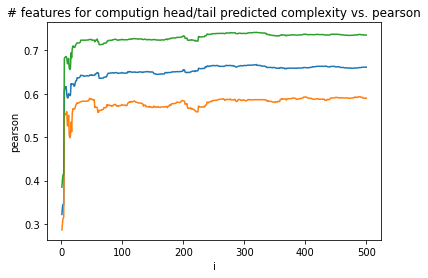

In [72]:
plt.plot(i, head_pearson, label='head')
plt.plot(i, tail_pearson, label='tail')
plt.plot(i, both_pearson, label='both')
plt.title('# features for computign head/tail predicted complexity vs. pearson')
plt.xlabel('i')
plt.ylabel('pearson')

## Filter method: K-best by mutual information
- Alternative script in `feature_selection_multi.py`.
- Results below _supposedly_ same as that in `multi_train_mi.txt`.

In [15]:
single_feature_names, single_mi = get_sorted_mi('./data/'+job+'/single_train_mi.txt')

In [16]:
picks = sorted(single_feature_names[:300])

## Filter method: Remove constant and quasi-constant features

In [17]:
# combined_pred_complexity
picks = [pick for pick in picks if single_X[:, single_train_feature_name_2_idx[pick]].std() != 0]
# remove quasi-constant features
col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in picks])
selector = VarianceThreshold(threshold=0.01)  # 0.1 indicates 99% of observations approximately
_ = selector.fit(single_X[:, col_idx])  # fit finds the features with low variance
picks = [pick for i, pick in enumerate(picks) if selector.get_support()[i]]

## Gather head, tail, both features

In [20]:
multi_feature_names, multi_mi = get_sorted_mi('./data/'+job+'/multi_train_mi.txt')

In [21]:
head_specific_feature_names = []
tail_specific_feature_names = []
both_specific_feature_names = []
neither_specific_feature_names = []
for feature_name in multi_feature_names:
    if re.search(r'_head$', feature_name) or re.search(r'_head_\d', feature_name):
        if ''.join(feature_name.rsplit('_head', 1)) not in picks:
            continue
        head_specific_feature_names.append(feature_name)
    elif re.search(r'_tail$', feature_name) or re.search(r'_tail_\d', feature_name):
        if ''.join(feature_name.rsplit('_tail', 1)) not in picks:
            continue
        tail_specific_feature_names.append(feature_name)
    elif re.search(r'_sum$', feature_name) or re.search(r'_sum_\d', feature_name):
        if ''.join(feature_name.rsplit('_sum', 1)) not in picks:
            continue
        both_specific_feature_names.append(feature_name)
    elif feature_name in picks:
        neither_specific_feature_names.append(feature_name)
head_and_neither_specific_feature_names = sorted(head_specific_feature_names+neither_specific_feature_names, key=lambda x: re.sub('_head_', '', re.sub('_head$', '', x)))
tail_and_neither_specific_feature_names = sorted(tail_specific_feature_names+neither_specific_feature_names, key=lambda x: re.sub('_tail_', '', re.sub('_tail$', '', x)))
both_and_neither_specific_feature_names = sorted(both_specific_feature_names+neither_specific_feature_names, key=lambda x: re.sub('_sum_', '', re.sub('_sum$', '', x)))

mapping = {multi_feature_name: multi_i for multi_feature_name, multi_i in zip(multi_feature_names, multi_mi) if multi_feature_name in head_and_neither_specific_feature_names or multi_feature_name in tail_and_neither_specific_feature_names or multi_feature_name in both_and_neither_specific_feature_names}

In [23]:
w = 0.5
col_idx = np.array([single_train_feature_name_2_idx[pick] for pick in picks])
single_X_picks = single_X[:, col_idx]
col_idx = np.array([multi_train_feature_name_2_idx[pick] for pick in head_and_neither_specific_feature_names])
multi_X_head_picks = multi_X[:, col_idx]
col_idx = np.array([multi_train_feature_name_2_idx[pick] for pick in tail_and_neither_specific_feature_names])
multi_X_tail_picks = multi_X[:, col_idx]
col_idx = np.array([multi_train_feature_name_2_idx[pick] for pick in both_and_neither_specific_feature_names])
multi_X_both_picks = w*multi_X_head_picks+(1-w)*multi_X_tail_picks
col_idx = np.array([multi_trial_feature_name_2_idx[pick] for pick in head_and_neither_specific_feature_names])
multi_X_trial_head_picks = multi_X_trial[:, col_idx]
col_idx = np.array([multi_trial_feature_name_2_idx[pick] for pick in tail_and_neither_specific_feature_names])
multi_X_trial_tail_picks = multi_X_trial[:, col_idx]
col_idx = np.array([multi_trial_feature_name_2_idx[pick] for pick in both_and_neither_specific_feature_names])
multi_X_trial_both_picks = w*multi_X_trial_head_picks+(1-w)*multi_X_trial_tail_picks
col_idx = np.array([multi_test_feature_name_2_idx[pick] for pick in head_and_neither_specific_feature_names])
multi_X_test_head_picks = multi_X_test[:, col_idx]
col_idx = np.array([multi_test_feature_name_2_idx[pick] for pick in tail_and_neither_specific_feature_names])
multi_X_test_tail_picks = multi_X_test[:, col_idx]
col_idx = np.array([multi_test_feature_name_2_idx[pick] for pick in both_and_neither_specific_feature_names])
multi_X_test_both_picks = w*multi_X_test_head_picks+(1-w)*multi_X_test_tail_picks

In [24]:
scaler = StandardScaler()
single_X_picks_scaled = scaler.fit_transform(single_X_picks)
multi_X_head_picks_scaled = scaler.transform(multi_X_head_picks)
multi_X_tail_picks_scaled = scaler.transform(multi_X_tail_picks)
multi_X_both_picks_scaled = scaler.transform(multi_X_both_picks)
multi_X_trial_head_picks_scaled = scaler.transform(multi_X_trial_head_picks)
multi_X_trial_tail_picks_scaled = scaler.transform(multi_X_trial_tail_picks)
multi_X_trial_both_picks_scaled = scaler.transform(multi_X_trial_both_picks)
multi_X_test_head_picks_scaled = scaler.transform(multi_X_test_head_picks)
multi_X_test_tail_picks_scaled = scaler.transform(multi_X_test_tail_picks)
multi_X_test_both_picks_scaled = scaler.transform(multi_X_test_both_picks)

In [26]:
model = XGBRegressor(colsample_bytree=0.7,learning_rate=0.03,max_depth=5,min_child_weight=4,n_estimators=225,nthread=4,objective='reg:linear',silent=1,subsample=0.7)
model = model.fit(single_X_picks_scaled, single_y)
multi_y_head_pred = model.predict(multi_X_head_picks_scaled)
multi_train['head_pred_complexity'] = multi_y_head_pred
multi_y_tail_pred = model.predict(multi_X_tail_picks_scaled)
multi_train['tail_pred_complexity'] = multi_y_tail_pred
multi_y_both_pred = model.predict(multi_X_both_picks_scaled)
multi_train['both_pred_complexity'] = multi_y_both_pred
multi_y_trial_head_pred = model.predict(multi_X_trial_head_picks_scaled)
multi_trial['head_pred_complexity'] = multi_y_trial_head_pred
multi_y_trial_tail_pred = model.predict(multi_X_trial_tail_picks_scaled)
multi_trial['tail_pred_complexity'] = multi_y_trial_tail_pred
multi_y_trial_both_pred = model.predict(multi_X_trial_both_picks_scaled)
multi_trial['both_pred_complexity'] = multi_y_trial_both_pred
multi_y_test_head_pred = model.predict(multi_X_test_head_picks_scaled)
multi_test['head_pred_complexity'] = multi_y_test_head_pred
multi_y_test_tail_pred = model.predict(multi_X_test_tail_picks_scaled)
multi_test['tail_pred_complexity'] = multi_y_test_tail_pred
multi_y_test_both_pred = model.predict(multi_X_test_both_picks_scaled)
multi_test['both_pred_complexity'] = multi_y_test_both_pred

[00:32:35] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:32:35] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [27]:
speed_up = np.concatenate([multi_X_head_picks_scaled, multi_X_tail_picks_scaled, multi_X_both_picks_scaled, multi_X_trial_head_picks_scaled, multi_X_trial_tail_picks_scaled, multi_X_trial_both_picks_scaled, multi_X_test_head_picks_scaled, multi_X_test_tail_picks_scaled, multi_X_test_both_picks_scaled], axis=0)

In [28]:
speed_up_pred = get_predictions_with_reduced_data(single_train, single_X_picks_scaled, single_y, speed_up, frac_1=0.87, frac_2=0.95, frac_3=0.82, frac_4=0.0, frac_5=0.0, n=10)

  0%|          | 0/10 [00:00<?, ?it/s][00:34:25] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:25] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 10%|█         | 1/10 [00:13<01:57, 13.04s/it][00:34:39] WARNING: ../src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:34:39] WARNING: ../src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 20%|██        | 2/10 [00:

In [29]:
offset = 0
multi_y_head_pred = speed_up_pred[offset:offset+multi_X_head_picks_scaled.shape[0]]
multi_train['class_4_5_head_pred_complexity'] = multi_y_head_pred
offset += multi_X_head_picks_scaled.shape[0]
multi_y_tail_pred = speed_up_pred[offset:offset+multi_X_tail_picks_scaled.shape[0]]
multi_train['class_4_5_tail_pred_complexity'] = multi_y_tail_pred
offset += multi_X_tail_picks_scaled.shape[0]
multi_y_both_pred = speed_up_pred[offset:offset+multi_X_both_picks_scaled.shape[0]]
multi_train['class_4_5_both_pred_complexity'] = multi_y_both_pred
offset += multi_X_both_picks_scaled.shape[0]
multi_y_trial_head_pred = speed_up_pred[offset:offset+multi_X_trial_head_picks_scaled.shape[0]]
multi_trial['class_4_5_head_pred_complexity'] = multi_y_trial_head_pred
offset += multi_X_trial_head_picks_scaled.shape[0]
multi_y_trial_tail_pred = speed_up_pred[offset:offset+multi_X_trial_tail_picks_scaled.shape[0]]
multi_trial['class_4_5_tail_pred_complexity'] = multi_y_trial_tail_pred
offset += multi_X_trial_tail_picks_scaled.shape[0]
multi_y_trial_both_pred = speed_up_pred[offset:offset+multi_X_trial_both_picks_scaled.shape[0]]
multi_trial['class_4_5_both_pred_complexity'] = multi_y_trial_both_pred
offset += multi_X_trial_both_picks_scaled.shape[0]
multi_y_test_head_pred = speed_up_pred[offset:offset+multi_X_test_head_picks_scaled.shape[0]]
multi_test['class_4_5_head_pred_complexity'] = multi_y_test_head_pred
offset += multi_X_test_head_picks_scaled.shape[0]
multi_y_test_tail_pred = speed_up_pred[offset:offset+multi_X_test_tail_picks_scaled.shape[0]]
multi_test['class_4_5_tail_pred_complexity'] = multi_y_test_tail_pred
offset += multi_X_test_tail_picks_scaled.shape[0]
multi_y_test_both_pred = speed_up_pred[offset:offset+multi_X_test_both_picks_scaled.shape[0]]
multi_test['class_4_5_both_pred_complexity'] = multi_y_test_both_pred
offset += multi_X_test_both_picks_scaled.shape[0]

In [30]:
# using best_thresh from pipeline_single.ipynb
best_thresh = 0.59
multi_train['combined_head_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_train['class_4_5_head_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_train['head_pred_complexity'].to_numpy())]
multi_train['combined_tail_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_train['class_4_5_tail_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_train['tail_pred_complexity'].to_numpy())]
multi_train['combined_both_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_train['class_4_5_both_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_train['both_pred_complexity'].to_numpy())]
multi_trial['combined_head_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_trial['class_4_5_head_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_trial['head_pred_complexity'].to_numpy())]
multi_trial['combined_tail_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_trial['class_4_5_tail_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_trial['tail_pred_complexity'].to_numpy())]
multi_trial['combined_both_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_trial['class_4_5_both_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_trial['both_pred_complexity'].to_numpy())]
multi_test['combined_head_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_test['class_4_5_head_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_test['head_pred_complexity'].to_numpy())]
multi_test['combined_tail_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_test['class_4_5_tail_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_test['tail_pred_complexity'].to_numpy())]
multi_test['combined_both_pred_complexity'] = [pred_complexity if pred_complexity < best_thresh else multi_test['class_4_5_both_pred_complexity'].to_numpy()[i] for i, pred_complexity in enumerate(multi_test['both_pred_complexity'].to_numpy())]

In [31]:
multi_train_mini_idx, multi_dev_mini_idx = np.load('./data/'+job+'/multi_train_mini_idx.npy'), np.load('./data/'+job+'/multi_dev_mini_idx.npy')
multi_train_mini = multi_train.iloc[multi_train_mini_idx]
multi_dev_mini = multi_train.iloc[multi_dev_mini_idx]
multi_X_train_mini = multi_X[multi_train_mini_idx, :]
multi_y_train_mini = multi_y[np.array(multi_train_mini_idx)]
multi_X_dev_mini = multi_X[multi_dev_mini_idx, :]
multi_y_dev_mini = multi_y[np.array(multi_dev_mini_idx)]
with open('./data/'+job+'/colab/multi_dev_mini_both_bert_scores.json', 'r') as file:
    multi_dev_mini_bert_scores = json.load(file)
    multi_dev_mini['bert_both_pred_complexity'] = multi_dev_mini_bert_scores['scores']
with open('./data/'+job+'/colab/multi_dev_mini_head_bert_scores.json', 'r') as file:
    multi_dev_mini_bert_scores = json.load(file)
    multi_dev_mini['bert_head_pred_complexity'] = multi_dev_mini_bert_scores['scores']
with open('./data/'+job+'/colab/multi_dev_mini_tail_bert_scores.json', 'r') as file:
    multi_dev_mini_bert_scores = json.load(file)
    multi_dev_mini['bert_tail_pred_complexity'] = multi_dev_mini_bert_scores['scores']

In [32]:
with open('./data/'+job+'/colab/multi_trial_bert_scores.json', 'r') as file:
    multi_trial_bert_scores = json.load(file)
    multi_trial['bert_both_pred_complexity'] = multi_trial_bert_scores['scores']
with open('./data/'+job+'/colab/multi_trial_head_bert_scores.json', 'r') as file:
    multi_trial_head_bert_scores = json.load(file)
    multi_trial['bert_head_pred_complexity'] = multi_trial_head_bert_scores['scores']
with open('./data/'+job+'/colab/multi_trial_tail_bert_scores.json', 'r') as file:
    multi_trial_tail_bert_scores = json.load(file)
    multi_trial['bert_tail_pred_complexity'] = multi_trial_tail_bert_scores['scores']

In [33]:
with open('./data/'+job+'/colab/multi_test_bert_scores.json', 'r') as file:
    multi_test_bert_scores = json.load(file)
    multi_test['bert_both_pred_complexity'] = multi_test_bert_scores['scores']
with open('./data/'+job+'/colab/multi_test_head_bert_scores.json', 'r') as file:
    multi_test_head_bert_scores = json.load(file)
    multi_test['bert_head_pred_complexity'] = multi_test_head_bert_scores['scores']
with open('./data/'+job+'/colab/multi_test_tail_bert_scores.json', 'r') as file:
    multi_test_tail_bert_scores = json.load(file)
    multi_test['bert_tail_pred_complexity'] = multi_test_tail_bert_scores['scores']

In [28]:
multi_X_picks = None
p_lst = []
for feature_name, mi in tqdm(list(mapping.items())[:100]):
    model = LinearRegression()
    col_idx = multi_train_feature_name_2_idx[feature_name]
    if multi_X_picks is None:
        multi_X_picks = multi_X[:, col_idx].reshape(-1,1)
    else:
        multi_X_picks = np.hstack([multi_X_picks, multi_X[:, col_idx].reshape(-1,1)])
    '''
    p_s = cross_val_score(model, multi_X_picks, multi_y, scoring=make_scorer(pearson), cv=custom_cv_folds(multi_train, n_splits=5))
    p = np.mean(p_s)
    p_lst.append(p)
    '''

100%|██████████| 100/100 [00:00<00:00, 1351.53it/s]


In [152]:
np.array(p_lst)

array([0.22916173, 0.46329415, 0.3715567 , 0.43611915, 0.44765836,
       0.41131373, 0.39048853, 0.46762718, 0.43569487, 0.40933185,
       0.40092858, 0.32358499, 0.67872939, 0.65666623, 0.67926543,
       0.71755822, 0.69617908, 0.70663538, 0.6824637 , 0.69307668,
       0.71971422, 0.68841165, 0.7035469 , 0.69018207, 0.70798546,
       0.73071195, 0.71752218, 0.71774087, 0.69815512, 0.66602833,
       0.69316429, 0.57880438, 0.68922587, 0.71025467, 0.73862944,
       0.71583485, 0.71376994, 0.72025741, 0.71932415, 0.75691645,
       0.7451323 , 0.71968159, 0.73084387, 0.72552951, 0.70421023,
       0.72263347, 0.73581115, 0.71680271, 0.70697466, 0.61491148,
       0.7346347 , 0.73416966, 0.71572795, 0.72349337, 0.67501583,
       0.71311677, 0.6963605 , 0.75248355, 0.6922448 , 0.63314566,
       0.6163511 , 0.73020026, 0.71935573, 0.70029893, 0.70290826,
       0.68805092, 0.70118104, 0.72598845, 0.72529974, 0.7308813 ,
       0.72949325, 0.63229973, 0.70759562, 0.71814022, 0.69952

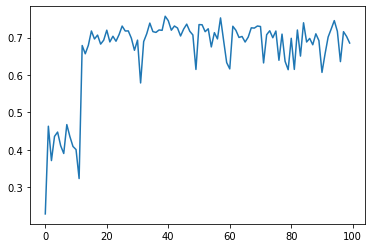

In [150]:
plt.plot(range(100), p_lst)

In [34]:
picks = multi_feature_names[:20]
#picks = ['tf_summed_bpe_sum', 'Lg10CD_sum', 'log_tf_lemma_sum', 'log_Cdlow_head', 'log_CDcount_tail', 'log_tf_head', 'log_FREQcount_head', 'glove_word_head_277', 'log_FREQlow_tail', 'FREQlow_tail', 'SUBTLWF_tail', 'glove_word_sum_201', 'glove_word_head_173', 'log_google_ngram_2_head_sum', 'log_tf_ngram_2_head', 'log_tf_ngram_3_sum', 'log_google_ngram_2_min_tail', 'glove_word_tail_151', 'glove_word_tail_221', 'glove_word_head_210', 'glove_word_tail_173', 'log_word_len_sum', 'log_google_ngram_3_mid_sum', 'log_google_ngram_3_tail_head', 'elmo_word_head_21', 'log_google_ngram_3_std_sum', 'tfidf_ngram_3_tail', 'glove_word_head_236', 'log_tf_ngram_2_tail', 'log_google_ngram_2_tail_sum', 'elmo_word_sum_488', 'log_google_ngram_3_std_tail', 'glove_word_head_68', 'glove_word_tail_207', 'log_tfidf_ngram_3_tail', 'google_ngram_3_head_head', 'glove_word_sum_215', 'log_google_ngram_3_head_tail', 'glove_word_tail_161', 'glove_word_tail_132', 'glove_word_sum_44', 'log_google_ngram_3_mean_sum', 'glove_word_tail_175', 'glove_word_tail_41', 'glove_word_sum_99', 'log_google_ngram_3_max_sum', 'glove_word_head_196', 'glove_word_head_279', 'DaleChallIndex', 'glove_context_277', 'glove_word_head_149', 'glove_word_head_248', 'glove_word_tail_208', 'elmo_word_tail_417', 'glove_word_tail_246', 'glove_word_sum_174', 'glove_word_sum_66', 'glove_word_head_150', 'glove_word_head_237', 'glove_word_tail_200', 'glove_word_head_117', 'glove_word_tail_125', 'glove_word_tail_253', 'glove_word_sum_140', 'log_google_ngram_3_tail_sum', 'glove_word_head_36', 'glove_word_head_18', 'glove_word_sum_237', 'glove_word_head_52', 'glove_word_head_104', 'glove_word_head_252', 'elmo_word_tail_726', 'glove_word_tail_131', 'glove_word_tail_63', 'glove_word_head_156', 'glove_word_sum_243', 'glove_word_tail_176', 'glove_word_sum_132', 'glove_word_tail_2', 'glove_word_tail_87', 'tfidf_head', 'glove_word_tail_238', 'glove_word_head_298', 'glove_word_sum_14', 'glove_word_tail_211', 'glove_word_tail_152', 'glove_word_tail_44', 'glove_word_head_198', 'glove_word_sum_11', 'glove_word_head_283', 'glove_word_head_15', 'glove_word_head_161', 'glove_word_sum_216', 'glove_word_sum_27', 'glove_word_head_213', 'glove_word_tail_235', 'glove_word_tail_51', 'glove_word_head_129', 'glove_word_sum_65', 'glove_word_head_136', 'glove_word_sum_103', 'glove_word_head_76', 'glove_word_head_26', 'google_ngram_3_min_tail', 'glove_word_head_131', 'glove_word_head_292', 'glove_word_tail_187', 'glove_word_sum_278', 'glove_word_tail_61', 'glove_word_head_128', 'glove_word_sum_183', 'glove_word_tail_188', 'glove_word_tail_251', 'glove_word_head_59', 'glove_word_tail_105', 'elmo_word_tail_573', 'glove_word_tail_189', 'glove_word_head_251', 'glove_word_sum_143', 'glove_word_head_158', 'log_phoneme_transition_max_tail', 'glove_word_sum_102', 'glove_word_sum_139', 'glove_word_tail_13', 'glove_word_tail_118', 'glove_word_sum_125', 'glove_word_tail_30', 'glove_word_sum_108', 'phoneme_transition_max_tail', 'glove_word_tail_116', 'glove_word_sum_29', 'glove_word_head_67', 'glove_word_sum_83', 'is_acronym_sum', 'glove_word_tail_56', 'glove_word_tail_264', 'log_is_pronoun_sum', 'glove_word_tail_192', 'glove_word_head_170', 'glove_word_tail_55', 'glove_word_sum_16', 'glove_word_sum_87', 'glove_word_sum_93', 'glove_word_sum_193', 'glove_word_tail_5', 'glove_word_tail_6', 'glove_word_tail_26', 'elmo_word_sum_573', 'elmo_word_sum_848', 'log_tfidf_ngram_2_sum']#[:20]
col_idx = [multi_train_feature_name_2_idx[pick] for pick in picks]
multi_X_picks = multi_X[:, col_idx]
multi_X_train_mini_picks = multi_X_picks[multi_train_mini_idx, :]
multi_X_dev_mini_picks = multi_X_picks[multi_dev_mini_idx, :]
col_idx = [multi_trial_feature_name_2_idx[pick] for pick in picks]
multi_X_trial_picks = multi_X_trial[:, col_idx]
col_idx = [multi_test_feature_name_2_idx[pick] for pick in picks]
multi_X_test_picks = multi_X_test[:, col_idx]

In [37]:
scaler = StandardScaler()
multi_X_picks_scaled = scaler.fit_transform(multi_X_picks)
multi_X_dev_mini_picks_scaled = scaler.transform(multi_X_dev_mini_picks)
multi_X_trial_picks_scaled = scaler.transform(multi_X_trial_picks)
multi_X_test_picks_scaled = scaler.transform(multi_X_test_picks)

In [40]:
model = LinearRegression()
model = model.fit(multi_X_picks_scaled, multi_y)
multi_y_dev_mini_pred = model.predict(multi_X_dev_mini_picks_scaled)
multi_y_trial_pred = model.predict(multi_X_trial_picks_scaled)
multi_y_test_pred = model.predict(multi_X_test_picks_scaled)
pearson(multi_y_dev_mini_pred, multi_dev_mini['complexity']), pearson(multi_y_trial_pred, multi_trial['complexity']), pearson(multi_y_test_pred, multi_test['complexity']),  MAE(multi_y_test_pred, multi_test['complexity'])

(0.7556485430202678, 0.720616818646654, 0.795861998928905, 0.07473506645593118)

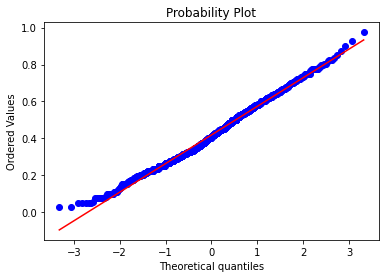

In [399]:
fig = plt.figure()
res = stats.probplot(multi_train['complexity'], plot=plt)
plt.show()

In [499]:
best_score = np.nan
best_weights = np.nan
for w1 in tqdm(np.arange(0, 1, 0.2)):
    for w2 in np.arange(0, 1, 0.2):
        for w3 in np.arange(0, 1, 0.2):
            for w4 in np.arange(0, 1, 0.2):
                for w5 in np.arange(0, 1, 0.2):
                    for w6 in np.arange(0, 1, 0.2):
                        for w7 in np.arange(0, 1, 0.2):
                            w_sum = w1+w2+w3+w4+w5+w6+w7
                            if w_sum > 0:
                                w1, w2, w3, w4, w5, w6, w7 = w1/w_sum, w2/w_sum, w3/w_sum, w4/w_sum, w5/w_sum, w6/w_sum, w7/w_sum
                            multi_y_dev_mini_pred_combined = w1*multi_y_dev_mini_pred+w2*multi_dev_mini['bert_both_pred_complexity']+w3*multi_dev_mini['bert_head_pred_complexity']+w4*multi_dev_mini['bert_tail_pred_complexity']+w5*multi_dev_mini['combined_both_pred_complexity']+w6*multi_dev_mini['combined_head_pred_complexity']+w7*multi_dev_mini['combined_tail_pred_complexity']
                            #s = pearson(multi_y_trial_pred_combined, multi_y_trial)
                            s = MAE(multi_y_dev_mini_pred_combined, multi_y_dev_mini)
                            #if np.isnan(best_score) or s > best_score:
                            if np.isnan(best_score) or s < best_score:
                                best_score = s
                                best_weights = (w1, w2, w3, w4, w5, w6, w7)

100%|██████████| 5/5 [03:52<00:00, 46.40s/it]


In [500]:
#MAE dev_mini
best_score, best_weights

(0.07501173974511614, (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0))

In [496]:
#MAE trial
best_score, best_weights

(0.08147894362581759,
 (0.0, 0.8333333333333334, 0.0, 0.0, 0.0, 0.0, 0.16666666666666669))

In [43]:
#pearson dream
#w2, w6, w7 = 0.40983878844383653, 0.40983334270370453, 0.18032786885245905
#pearson og
w2, w6, w7 = 0.5547862519528476, 0.27854708138048573, 0.16666666666666669
#pearson ok
#w2, w6, w7 = 0.4498266907725791, 0.22584898490309652, 0.32432432432432434
#MAE trial
#w2, w6, w7 = 0.8333333333333334, 0, 0.16666666666666669
#MAE dev_mini
#w2, w6, w7 = 1, 0, 0
multi_y_dev_mini_pred_combined = w2*multi_dev_mini['bert_both_pred_complexity']+w6*multi_dev_mini['combined_head_pred_complexity']+w7*multi_dev_mini['combined_tail_pred_complexity']
multi_dev_mini['pred_complexity'] = multi_y_dev_mini_pred_combined
multi_y_trial_pred_combined = w2*multi_trial['bert_both_pred_complexity']+w6*multi_trial['combined_head_pred_complexity']+w7*multi_trial['combined_tail_pred_complexity']
multi_trial['pred_complexity'] = multi_y_trial_pred_combined
multi_y_test_pred_combined = w2*multi_test['bert_both_pred_complexity']+w6*multi_test['combined_head_pred_complexity']+w7*multi_test['combined_tail_pred_complexity']
multi_test['pred_complexity'] = multi_y_test_pred_combined
pearson(multi_y_test_pred_combined, multi_test['complexity']), spearman(multi_y_test_pred_combined, multi_test['complexity']), MAE(multi_y_test_pred_combined, multi_test['complexity'])

(0.8289666317447416, 0.8119977471712612, 0.0856609730452085)

In [48]:
foo = multi_y_test_pred_combined
pearson(foo, multi_test['complexity']), spearman(foo, multi_test['complexity']), MAE(foo, multi_test['complexity'])

(0.8289666317447416, 0.8119977471712612, 0.0856609730452085)

In [364]:
pkl.dump(multi_X, open('X_picks.pkl', 'wb'))
pkl.dump(multi_feature_names, open('picks.pkl', 'wb'))

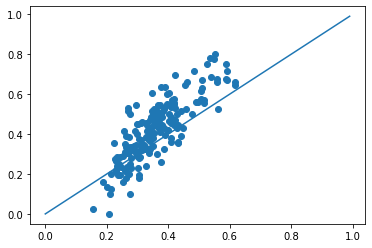

In [91]:
plt.scatter(multi_y_test_pred_combined, multi_test['complexity'])
plt.plot(np.arange(0,1,.01), np.arange(0,1,.01))

In [435]:
foo = multi_X
baz = pd.DataFrame(foo, columns=multi_train_feature_name_2_idx.keys())
baz['complexity'] = multi_train['complexity']
baz['token'] = multi_train['token']
baz['sentence'] = multi_train['sentence']
baz['combined_head_pred_complexity'] = multi_train['combined_head_pred_complexity']
baz['combined_tail_pred_complexity'] = multi_train['combined_tail_pred_complexity']
baz['combined_both_pred_complexity'] = multi_train['combined_both_pred_complexity']
baz = baz[baz.columns[-6:].tolist()+baz.columns[:-6].tolist()] 
baz_reduced = baz[(baz['complexity'] < 0.25) & (baz['complexity'] < np.inf)].sort_values('complexity')

In [304]:
corr = baz_reduced[baz_reduced.columns[3:]].apply(lambda x: x.corr(baz_reduced['complexity']))

In [305]:
corr.abs().sort_values(ascending=False).head(20)

corpus_europarl              0.277599
log_corpus_europarl          0.277599
elmo_word_head_435           0.273787
glove_word_tail_223          0.260722
infersent_embeddings_3189    0.239969
elmo_word_tail_199           0.237732
elmo_word_tail_480           0.232883
elmo_word_sum_480            0.232643
infersent_embeddings_2459    0.231846
glove_context_184            0.231192
POS_VBG_sum                  0.231042
POS_VBG_head                 0.231042
log_POS_VBG_head             0.231042
log_POS_VBG_sum              0.231042
elmo_word_tail_42            0.230139
glove_word_tail_208          0.228255
elmo_word_sum_180            0.227631
tf_lemma_tail                0.225177
elmo_word_tail_370           0.221991
infersent_embeddings_3268    0.221089
dtype: float64

In [336]:
parameter = 20
picks = corr.abs().sort_values(ascending=False).index.tolist()
if 'pred_complexity' in picks: picks.remove('pred_complexity')
if 'complexity' in picks:  picks.remove('complexity')
picks = picks[:parameter]

In [337]:
col_idx = [multi_train_feature_name_2_idx[pick] for pick in picks]
multi_X_reduced_picks = multi_X[:, col_idx]
multi_X_reduced_picks = multi_X_reduced_picks[baz_reduced.index.to_numpy()]
col_idx = [multi_trial_feature_name_2_idx[pick] for pick in picks]
multi_X_trial_picks = multi_X_trial[:, col_idx]
col_idx = [multi_test_feature_name_2_idx[pick] for pick in picks]
multi_X_test_picks = multi_X_test[:, col_idx]

In [338]:
scaler = StandardScaler()
multi_X_reduced_picks_scaled = scaler.fit_transform(multi_X_reduced_picks)
multi_X_trial_picks_scaled = scaler.transform(multi_X_trial_picks)
multi_X_test_picks_scaled = scaler.transform(multi_X_test_picks)

In [339]:
model = LinearRegression()
model = model.fit(multi_X_reduced_picks_scaled, multi_y[baz_reduced.index.to_numpy()])
multi_y_trial_reduced_pred_complexity = model.predict(multi_X_trial_picks_scaled)
multi_trial['reduced_pred_complexity'] = multi_y_trial_reduced_pred_complexity
multi_y_test_reduced_pred_complexity = model.predict(multi_X_test_picks_scaled)
multi_test['reduced_pred_complexity'] = multi_y_test_reduced_pred_complexity

In [358]:
multi_train[['complexity', 'google_ngram_2_head_tail']].corr()

,complexity,google_ngram_2_head_tail
complexity,1.000000,-0.160702
google_ngram_2_head_tail,-0.160702,1.000000


In [356]:
multi_train[['token']+[column for column in multi_train.columns if 'google' in column]]

,token,google_ngram_1_sum,google_ngram_1_head,google_ngram_1_tail,google_ngram_2_head_sum,google_ngram_2_head_head,google_ngram_2_head_tail,google_ngram_2_tail_sum,google_ngram_2_tail_head,google_ngram_2_tail_tail,...,log_google_ngram_3_min_tail,log_google_ngram_3_max_sum,log_google_ngram_3_max_head,log_google_ngram_3_max_tail,log_google_ngram_3_mean_sum,log_google_ngram_3_mean_head,log_google_ngram_3_mean_tail,log_google_ngram_3_std_sum,log_google_ngram_3_std_head,log_google_ngram_3_std_tail
0,seventh day,199760068,7010841,192749227,3983824.0,3478407.0,505417.0,2558774.0,505417.0,2053357.0,...,9.876990,13.511378,12.818232,12.818232,12.647203,11.823022,12.069898,12.846240,12.212927,12.089455
1,own work,418495343,194186830,224308513,57405316.0,56511858.0,893458.0,26573049.0,893458.0,25679591.0,...,12.116569,15.263745,12.699713,15.183626,14.317410,12.057375,14.207209,14.640764,11.987931,14.567708
2,loving kindness,12348119,7414492,4933627,233035.0,153011.0,80024.0,81891.0,80024.0,1867.0,...,5.123964,9.767038,9.073948,9.073948,9.037890,8.502756,8.157275,9.099300,8.380258,8.431611
3,loving kindness,12348119,7414492,4933627,242838.0,162814.0,80024.0,673509.0,80024.0,593485.0,...,0.000000,9.942660,9.249561,9.249561,9.347258,8.877428,8.366370,9.166540,8.329189,8.599583
4,loving kindness,12348119,7414492,4933627,242838.0,162814.0,80024.0,150249.0,80024.0,70225.0,...,7.823646,8.619930,7.926964,7.926964,8.387312,7.487920,7.865444,7.391657,7.297912,4.984841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,carcinogenic substances,8658576,346244,8312332,9347.0,342.0,9005.0,1279973.0,9005.0,1270968.0,...,0.000000,8.016648,7.180070,7.449498,7.335417,6.260855,6.918695,7.374251,6.546015,6.801209
1513,multilateral cooperation,9696407,787996,8908411,13895.0,1240.0,12655.0,689482.0,12655.0,676827.0,...,5.337538,12.121114,7.587311,12.110321,11.036775,6.699090,11.023638,11.564641,6.914738,11.555042
1514,institutional prerogatives,7164874,6474444,690430,16794.0,14652.0,2142.0,99048.0,2142.0,96906.0,...,0.000000,6.545350,5.624018,6.040255,5.782799,4.532599,5.449607,5.922483,5.077351,5.365925
1515,dioxin contamination,2328562,134326,2194236,8939.0,6706.0,2233.0,97815.0,2233.0,95582.0,...,0.000000,8.893710,4.644391,8.879472,7.809406,3.564827,7.795372,8.337489,4.102099,8.323152


In [353]:
multi_test[['token', 'sentence', 'complexity', 'pred_complexity', 'google_ngram_1_sum']].sort_values('complexity').head(50)

,token,sentence,complexity,pred_complexity,google_ngram_1_sum
98,important questions,The work presented here has clarified two impo...,0.000000,0.205974,152647176
63,only daughter,"for he had an only daughter, about twelve year...",0.025000,0.155947,438297908
104,complete agreement,These findings are in complete agreement with ...,0.100000,0.275979,70227164
57,high walls,All these were cities fortified with high wall...,0.100000,0.209676,161421727
54,weather today,"In the morning, 'It will be foul weather today...",0.125000,0.213159,56385981
89,many cases,Recent human genetic studies have also demonst...,0.132353,0.202061,345474043
46,young children,Her young children also were dashed in pieces ...,0.160714,0.187984,231341665
82,new possibilities,This technology should provide new possibiliti...,0.160714,0.252621,423962995
22,fig tree,"Judah and Israel lived safely, every man under...",0.178571,0.304856,77212086
39,pure gold,All king Solomon's drinking vessels were of go...,0.178571,0.261303,51274908


In [242]:
corr = baz_reduced[baz_reduced.columns[3:]].apply(lambda x: x.corr(baz_reduced['complexity']))

In [244]:
corr.abs().sort_values(ascending=False).head(20)

combined_both_pred_complexity    0.696572
combined_head_pred_complexity    0.675945
Lg10CD_sum                       0.645516
Lg10WF_sum                       0.630149
glove_word_sum_277               0.616216
log_CDcount_sum                  0.601748
log_tf_sum                       0.590281
log_Cdlow_sum                    0.589891
combined_tail_pred_complexity    0.585112
glove_word_sum_35                0.582408
log_FREQcount_sum                0.578509
log_tf_lemma_head                0.578491
log_tf_head                      0.578396
log_FREQlow_sum                  0.568686
log_SUBTLCD_sum                  0.561941
log_tf_lemma_sum                 0.559948
Lg10CD_head                      0.555476
log_CDcount_head                 0.555475
log_SUBTLWF_sum                  0.552890
log_CDcount_tail                 0.545052
dtype: float64

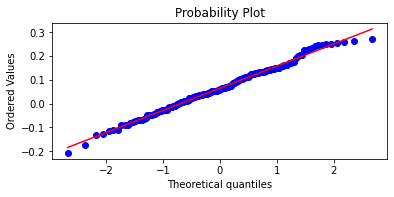

In [545]:
residuals = multi_test['complexity']-multi_test['pred_complexity']
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(residuals, plot=ax, fit=True)

In [537]:
multi_test['residual'] = residuals

In [543]:
multi_test.corr()['residual'].abs().sort_values(ascending=False)

residual            1.00000
complexity          0.81977
log_SUBTLCD_sum     0.39721
Lg10CD_sum          0.38678
log_SUBTLCD_head    0.38323
                     ...   
log_POS_CD_head         NaN
log_POS_CD_tail         NaN
log_POS_POS_sum         NaN
log_POS_POS_head        NaN
log_POS_POS_tail        NaN
Name: residual, Length: 571, dtype: float64

In [507]:
param = 20
thresh = 0.5
bins = np.arange(0, 1+1/(2*param), 1/param)
multi_trial['bin'] = np.digitize(multi_y_trial_pred_combined, bins)
multi_test['bin'] = np.digitize(multi_y_test_pred_combined, bins)
bin_2_residual = multi_trial.groupby('bin').apply(lambda x: (x['pred_complexity']-x['complexity']).mean())
multi_trial['adjusted_pred_complexity'] = multi_trial.apply(lambda x: x['pred_complexity']-bin_2_residual[x['bin']] if x['bin'] in bin_2_residual and x['pred_complexity'] > thresh else x['pred_complexity'], axis=1)
multi_test['adjusted_pred_complexity'] = multi_test.apply(lambda x: x['pred_complexity']-bin_2_residual[x['bin']] if x['bin'] in bin_2_residual and x['pred_complexity'] > thresh else x['pred_complexity'], axis=1)

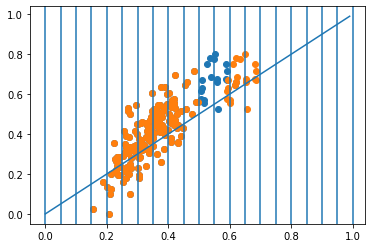

In [508]:
plt.scatter(multi_test['pred_complexity'], multi_test['complexity'])
plt.scatter(multi_test['adjusted_pred_complexity'], multi_test['complexity'])
plt.plot(np.arange(0,1,.01), np.arange(0,1,.01))
for item in bins:
    plt.axvline(x=item)


In [509]:
pearson(multi_test['pred_complexity'], multi_test['complexity']), pearson(multi_test['adjusted_pred_complexity'], multi_test['complexity']), MAE(multi_test['pred_complexity'], multi_test['complexity']), MAE(multi_test['adjusted_pred_complexity'], multi_test['complexity'])

(0.8333818942934074,
 0.8178078115177974,
 0.09133677069712122,
 0.08493610165033606)

In [203]:
pkl.dump(picks, open('./picks.pkl', 'wb'))
pkl.dump(multi_X_picks, open('./multi_X_picks.pkl', 'wb'))

In [269]:
multi_head_picks = single_picks_2_multi_picks(single_picks, single_feature_names, multi_feature_names, mode='head')
multi_tail_picks = single_picks_2_multi_picks(single_picks, single_feature_names, multi_feature_names, mode='tail')

# Playground

## First, create train_mini and dev_mini subsets from train set 

In [52]:
#multi_train_mini_idx, multi_dev_mini_idx = next(custom_cv_folds(multi_train, n_splits=1, test_size=0.1))
multi_train_mini_idx, multi_dev_mini_idx = np.load('./data/'+job+'/multi_train_mini_idx.npy'), np.load('./data/'+job+'/multi_dev_mini_idx.npy')
multi_train_mini = multi_train.iloc[multi_train_mini_idx]
multi_dev_mini = multi_train.iloc[multi_dev_mini_idx]
#np.save('./data/pickle/multi_train_mini_idx.npy', multi_train_mini_idx)
#np.save('./data/pickle/multi_dev_mini_idx.npy', multi_dev_mini_idx)
#preprocess_for_bert(multi_train_mini, './data/'+job+'/colab/multi_train_bert.tsv', do_round=False)
#preprocess_for_bert(multi_dev_mini, './data/'+job+'/colab/multi_dev_bert.tsv', do_round=False)

In [53]:
#picks = feature_names[:75]
picks = ['tf_summed_bpe_head']


In [54]:
col_idx = np.array([multi_train_feature_name_2_idx[pick] for pick in picks])
X_train_mini = X[multi_train_mini_idx, :]
X_dev_mini = X[multi_dev_mini_idx, :]
X_train_mini_picks = X_train_mini[:, col_idx]
X_dev_mini_picks = X_dev_mini[:, col_idx]
y_train_mini = y[np.array(multi_train_mini_idx)]
y_dev_mini = y[np.array(multi_dev_mini_idx)]

In [55]:
model = LinearRegression()
model = model.fit(X_train_mini_picks, y_train_mini)
y_dev_mini_pred = model.predict(X_dev_mini_picks)
MAE(y_dev_mini_pred, y_dev_mini), pearson(y_dev_mini_pred, y_dev_mini), spearman(y_dev_mini_pred, y_dev_mini)

(0.1298818755146545, 0.16523205971765065, 0.15763532092434604)

In [56]:
col_idx = np.array([multi_trial_feature_name_2_idx[pick] for pick in picks])
X_trial_picks = X_trial[:, col_idx]
y_trial_pred = model.predict(X_trial_picks)
MAE(y_trial_pred, y_trial), pearson(y_trial_pred, y_trial), spearman(y_trial_pred, y_trial)

(0.12401533344335097, 0.06528018917298345, 0.350208188646511)

## Slant

In [57]:
with open('./data/'+job+'/colab/multi_dev_mini_bert_scores.json', 'r') as file:
    multi_dev_bert_scores = json.load(file)
    multi_dev_mini['lr_pred_complexity'] = y_dev_mini_pred
    multi_dev_mini['bert_pred_complexity'] = multi_dev_bert_scores['scores']
    multi_dev_mini['mean_pred_complexity'] = multi_dev_mini[['lr_pred_complexity', 'bert_pred_complexity']].mean(axis=1)

In [58]:
with open('./data/'+job+'/colab/multi_trial_bert_scores.json', 'r') as file:
    multi_trial_bert_scores = json.load(file)
    multi_trial['lr_pred_complexity'] = y_trial_pred
    multi_trial['bert_pred_complexity'] = multi_trial_bert_scores['scores']
    multi_trial['mean_pred_complexity'] = multi_trial[['lr_pred_complexity', 'bert_pred_complexity']].mean(axis=1)

In [59]:
multi_trial[['complexity', 'lr_pred_complexity', 'bert_pred_complexity', 'mean_pred_complexity']].corr()

,complexity,lr_pred_complexity,bert_pred_complexity,mean_pred_complexity
complexity,1.000000,0.065280,0.733909,0.693268
lr_pred_complexity,0.065280,1.000000,0.247026,0.442134
bert_pred_complexity,0.733909,0.247026,1.000000,0.978370
mean_pred_complexity,0.693268,0.442134,0.978370,1.000000


In [60]:
class_incr = multi_dev_mini.groupby('class').apply(lambda x: x['complexity'].mean()-x['mean_pred_complexity'].mean())

In [61]:
multi_dev_mini['incr_mean_pred_complexity'] = multi_dev_mini.apply(lambda x: x['mean_pred_complexity'] + class_incr[x['class']], axis=1)

In [62]:
multi_dev_mini[['complexity', 'lr_pred_complexity', 'bert_pred_complexity', 'mean_pred_complexity', 'incr_mean_pred_complexity']].corr()

,complexity,lr_pred_complexity,bert_pred_complexity,mean_pred_complexity,incr_mean_pred_complexity
complexity,1.000000,0.165232,0.799397,0.794212,0.943299
lr_pred_complexity,0.165232,1.000000,0.150904,0.328723,0.247760
bert_pred_complexity,0.799397,0.150904,1.000000,0.983217,0.900863
mean_pred_complexity,0.794212,0.328723,0.983217,1.000000,0.906380
incr_mean_pred_complexity,0.943299,0.247760,0.900863,0.906380,1.000000


In [63]:
multi_trial['incr_mean_pred_complexity'] = multi_trial.apply(lambda x: x['mean_pred_complexity'] + class_incr[x['class']], axis=1)

In [64]:
multi_trial[['complexity', 'lr_pred_complexity', 'bert_pred_complexity', 'mean_pred_complexity', 'incr_mean_pred_complexity']].corr()

,complexity,lr_pred_complexity,bert_pred_complexity,mean_pred_complexity,incr_mean_pred_complexity
complexity,1.000000,0.065280,0.733909,0.693268,0.918760
lr_pred_complexity,0.065280,1.000000,0.247026,0.442134,0.225573
bert_pred_complexity,0.733909,0.247026,1.000000,0.978370,0.883505
mean_pred_complexity,0.693268,0.442134,0.978370,1.000000,0.865958
incr_mean_pred_complexity,0.918760,0.225573,0.883505,0.865958,1.000000


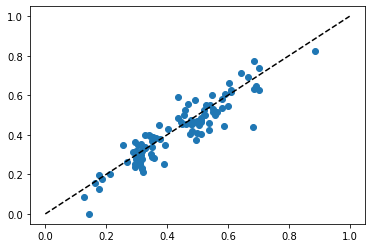

In [51]:
plt.scatter(multi_trial['incr_mean_pred_complexity'], multi_trial['complexity'])
plt.plot([0,1], [0,1], '--k')